# Modeling 111101011 - drop features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 534, 917, 1183, 1299) with all features.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111101011.csv")

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [11]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 2.16 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.011 (std: 0.003)
Parameters: {'alpha': 6.9007029891837757}

Model with rank: 2
Mean validation score: -0.011 (std: 0.003)
Parameters: {'alpha': 7.5784387149733536}

Model with rank: 3
Mean validation score: -0.011 (std: 0.003)
Parameters: {'alpha': 4.6977861173723729}



alpha                    RMSE                 std dev
0     1.0  0.10526025105944214477  0.05349985571433817089
13   14.0  0.10435909476911148230  0.05213884528330942764
1     2.0  0.10433356938753531040  0.05315572130518595589
12   13.0  0.10419087304512655856  0.05216998110381160930
11   12.0  0.10403180109858521651  0.05220363396860855376
10   11.0  0.10388404072396215105  0.05224042581108032796
2     3.0  0.10386582656524286083  0.05291118794753807419
9    10.0  0.10375042750524193780  0.05228122115583896945
8     9.0  0.10363475790502234275  0.05232724168549850174
3     4.0  0.10361641393599095584  0.05273987898095803400
7     8.0  0.10354223763060829699  0.05238024720544854490
4     5.0  0.10349605817626356119  0.05261462961125201038
6     7.0  0.10348020865659116052  0.05244283059928180057
5     6.0  0.10345938286525281635  0.05251891573542220859

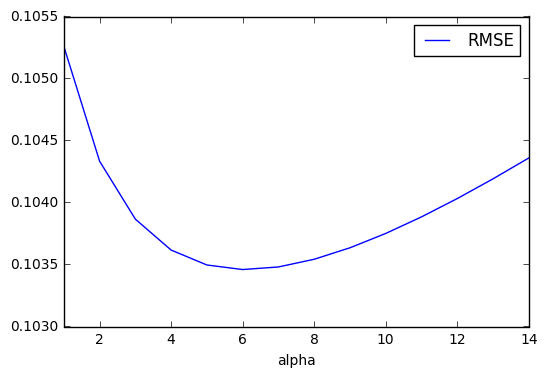

In [12]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [13]:
ridge_regr = linear_model.Ridge(alpha = 6)

In [14]:
validate(ridge_regr)

0.12381705668317267

## Lasso

In [15]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [16]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 41.08 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00022767379947278901}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00024702272550799624}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00024940913544266378}



alpha                    RMSE                 std dev
5  0.00060000000000000006  0.10396097841458405708  0.05114591549632593187
4  0.00050000000000000001  0.10351584195707694280  0.05144658233321838803
0  0.00010000000000000000  0.10345598530755073519  0.05422784254337709858
3  0.00040000000000000002  0.10293581896575101919  0.05198132361349575709
2  0.00030000000000000003  0.10223140801305137526  0.05283199119307575853
1  0.00020000000000000001  0.10204444218250327547  0.05339184256085816038

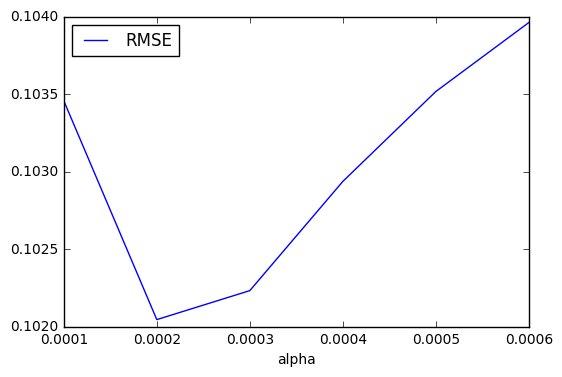

In [17]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [31]:
lasso_regr = linear_model.Lasso(alpha=0.0002, max_iter=50000)

In [32]:
validate(lasso_regr)

0.12055633832245496

## Lasso LARS

In [18]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [19]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 178 iterations, i.e. alpha=5.366e-05, with an active set of 154 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 226 iterations, i.e. alpha=2.282e-05, with an active set of 190 regressors, and the smallest cholesky pivot element being 2.107e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 222 iterations, i.e. alpha=2.772e-05, with an active set of 182 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

RandomizedSearchCV took 4.78 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 6.9871968699284005e-05}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 6.4598998214339957e-05}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 5.7320914083055796e-05}



/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 222 iterations, i.e. alpha=2.772e-05, with an active set of 182 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 234 iterations, i.e. alpha=2.576e-05, with an active set of 192 regressors, and the smallest cholesky pivot element being 2.220e-16
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 247 iterations, alpha=2.136e-05, previous alpha=2.126e-05, with an active set of 202 regressors.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/skl

alpha                    RMSE                 std dev
0  0.00002000000000000000  0.10374771969212891187  0.05411258642713143857
1  0.00003000000000000000  0.10270705610990832346  0.05368391098463046185
2  0.00004000000000000001  0.10220038620604109114  0.05370041072193709047
9  0.00011000000000000002  0.10213374232166674838  0.05261831176011733113
8  0.00010000000000000002  0.10193511651245469596  0.05275318709176256976
3  0.00005000000000000001  0.10189647610457869265  0.05345745097169644910
7  0.00009000000000000002  0.10182289793544806178  0.05288486968079892520
6  0.00008000000000000002  0.10171950779699355516  0.05299041662405094139
4  0.00006000000000000001  0.10171330948373313863  0.05317405292310656284
5  0.00007000000000000001  0.10165681619644022227  0.05304544795563220089

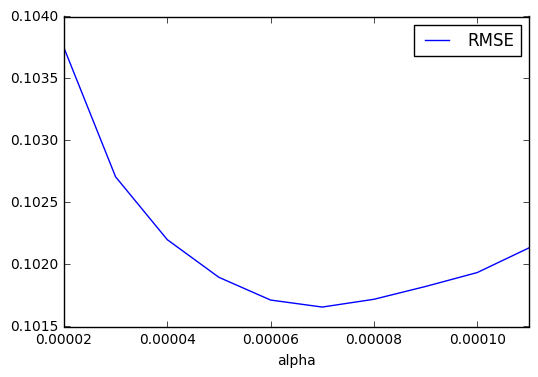

In [33]:
lassolars_params = {'alpha': np.arange(0.00002, 0.00012, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [34]:
lassolars_regr = linear_model.LassoLars(alpha=0.00007, max_iter=50000)

In [35]:
validate(lassolars_regr)

0.11680158881161026

## Elastic Net

In [21]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [22]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

RandomizedSearchCV took 18.35 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00035358233495160607, 'l1_ratio': 0.62445495910857396}

Model with rank: 2
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00043416833287797363, 'l1_ratio': 0.62470603036294114}

Model with rank: 3
Mean validation score: -0.010 (std: 0.003)
Parameters: {'alpha': 0.00032299893535103926, 'l1_ratio': 0.50461868741903337}



alpha                    RMSE                 std dev
0  0.00010000000000000000  0.10466988782840035144  0.05377250580053252044
1  0.00020000000000000001  0.10326048026641061750  0.05401852836131185859
8  0.00090000000000000008  0.10313072232319131505  0.05118811059535075675
7  0.00080000000000000004  0.10281776943307323335  0.05142412293743517382
6  0.00070000000000000010  0.10250379685245057659  0.05175669300415524504
2  0.00030000000000000003  0.10230564763321468857  0.05337334652506264820
5  0.00060000000000000006  0.10217504697494768362  0.05211407649020021599
4  0.00050000000000000001  0.10189428762141458651  0.05243180076169059317
3  0.00040000000000000002  0.10184323097231291755  0.05279955610031008412

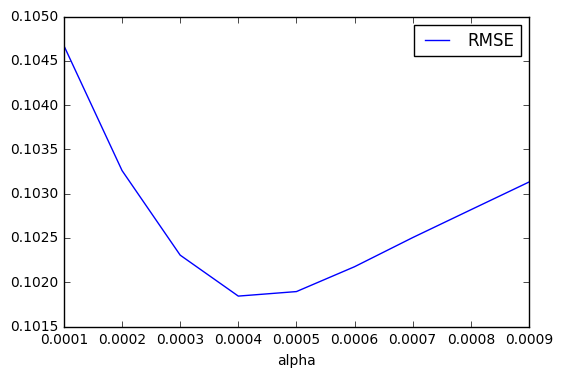

In [36]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.5, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0010, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

l1_ratio                    RMSE                 std dev
0  0.10000000000000000555  0.10441432388581213531  0.05348813671562054062
1  0.20000000000000001110  0.10346152464539486171  0.05371712493904876040
2  0.30000000000000004441  0.10265271857124085020  0.05343233380398759724
8  0.90000000000000002220  0.10260496058354055815  0.05228437429770904643
7  0.80000000000000004441  0.10226430794461338625  0.05248264236698847729
3  0.40000000000000002220  0.10214073038708404439  0.05310812616032029032
6  0.70000000000000006661  0.10200848688456552738  0.05255223581841998032
5  0.59999999999999997780  0.10184327606997581328  0.05269439763514369157
4  0.50000000000000000000  0.10184323097231291755  0.05279955610031008412

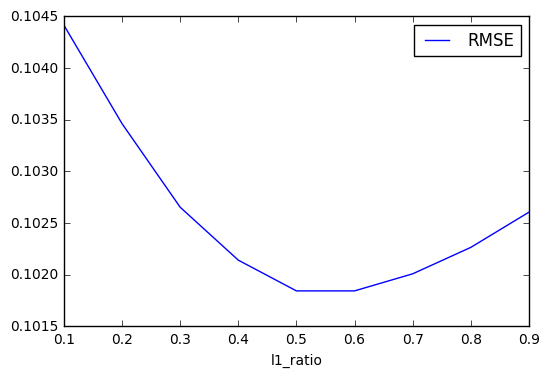

In [37]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [40]:
elnet_regr = linear_model.ElasticNet(alpha=0.0004, l1_ratio=0.55, max_iter=15000, random_state=7)

In [41]:
validate(elnet_regr)

0.12073617205416871

## Random Forest

In [24]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [25]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,40), 
             'max_features': scipy.stats.randint(5,80)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 162.12 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.003)
Parameters: {'max_features': 72, 'n_estimators': 282, 'max_depth': 25}

Model with rank: 2
Mean validation score: -0.014 (std: 0.003)
Parameters: {'max_features': 70, 'n_estimators': 352, 'max_depth': 17}

Model with rank: 3
Mean validation score: -0.014 (std: 0.003)
Parameters: {'max_features': 46, 'n_estimators': 289, 'max_depth': 17}



n_estimators                    RMSE                 std dev
0           50.0  0.12052795381919016726  0.05594726774489779814
1          100.0  0.11916286501764296324  0.05428178449016355517
2          150.0  0.11901574036657040778  0.05434199912361060286
3          200.0  0.11899647282743061605  0.05431382577925717575
11         600.0  0.11878123152013692065  0.05466817137953658423
10         550.0  0.11872252445870284943  0.05451418538502986189
7          400.0  0.11871672919410827807  0.05469634964345331668
4          250.0  0.11871037696408996698  0.05416976155895449757
5          300.0  0.11864325175796218426  0.05433330269589997652
8          450.0  0.11861659805287434744  0.05460913972698476504
9          500.0  0.11861005296124499386  0.05474181364205214784
6          350.0  0.11852405887389512451  0.05456756146583245648

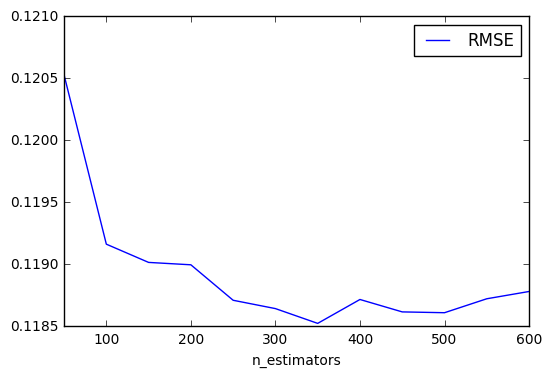

In [64]:
rf_regr = RandomForestRegressor(n_estimators = 282, max_depth = 19, max_features = 83, random_state = 7)
rf_params = {'n_estimators': np.arange(50, 650, 50).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [67]:
rf_regr = RandomForestRegressor(n_estimators = 350, max_depth = 19, max_features = 83, random_state = 7)

In [68]:
validate(rf_regr)

0.13784234045991373

## Support Vector Regressor

In [26]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [27]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 40.02 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.003)
Parameters: {'kernel': 'rbf', 'C': 2.9358211180120493, 'gamma': 0.012065525077584009}

Model with rank: 2
Mean validation score: -0.016 (std: 0.003)
Parameters: {'kernel': 'rbf', 'C': 0.31498347733449839, 'gamma': 0.031206931920776493}

Model with rank: 3
Mean validation score: -0.018 (std: 0.003)
Parameters: {'kernel': 'rbf', 'C': 0.77904200303571836, 'gamma': 0.040352999606096812}



C                    RMSE                 std dev
14  4.90000000000000124345  0.10830190248620419347  0.05026170177977128811
13  4.80000000000000071054  0.10829099151081894581  0.05023332045429666770
12  4.70000000000000106581  0.10827288624752626212  0.05016520808082025606
11  4.60000000000000142109  0.10825957996285219542  0.05012401145621370180
10  4.50000000000000088818  0.10823375147670935559  0.05004415557117992963
9   4.40000000000000035527  0.10820964720364141531  0.04998193022133261276
8   4.30000000000000071054  0.10817841727638895233  0.04994205705008515628
7   4.20000000000000106581  0.10816317845941648967  0.04989463169293069378
6   4.10000000000000053291  0.10813645436993160609  0.04982949460420339066
0   3.50000000000000000000  0.10810077242006609077  0.04981650066505426827
5   4.00000000000000000000  0.10809945356143692285  0.04978058278418839161
1   3.60000000000000008882  0.10807752207914998743  0.04979839510400229513
4   3.90000000000000035527  0.10807663622680388493  0.04976246207764635499
2   3.70000000000000017764  0.10806951944857370873  0.04976694836028680569
3   3.80000000000000026645  0.10805673143803964931  0.04974991935565278856

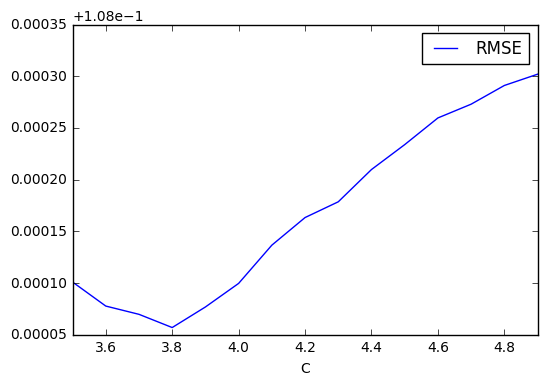

In [52]:
svr_regr = svm.SVR(C=2.9, cache_size=200, coef0=0.0, degree=3, gamma=0.005,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(3.5, 4.9, 0.1).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [58]:
svr_regr = svm.SVR(C=3.8, cache_size=200, coef0=0.0, degree=3, gamma=0.005,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [59]:
validate(svr_regr)

0.12738584699951028

## Orthogonal Matching Pursuit

In [28]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [29]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,120)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 4.32 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.003)
Parameters: {'n_nonzero_coefs': 98}

Model with rank: 2
Mean validation score: -0.012 (std: 0.003)
Parameters: {'n_nonzero_coefs': 99}

Model with rank: 3
Mean validation score: -0.012 (std: 0.003)
Parameters: {'n_nonzero_coefs': 106}



n_nonzero_coefs                    RMSE                 std dev
4              94.0  0.10985282407165070095  0.05534818101623038139
5              95.0  0.10970749994566754426  0.05500333587321945550
6              96.0  0.10962815345710832937  0.05468297208038691570
0              90.0  0.10959246076339962395  0.05580525156802912390
1              91.0  0.10956395006212514553  0.05483665231673771207
19            109.0  0.10945478236249374382  0.05361864002380221927
18            108.0  0.10937748692662832561  0.05305138582112080975
3              93.0  0.10936164694162861521  0.05512499536285215412
20            110.0  0.10933834891104278475  0.05330707614962705565
16            106.0  0.10933601678099787169  0.05312308424688637343
7              97.0  0.10931118155585985152  0.05472685262567827252
17            107.0  0.10929077484547669585  0.05304878561360591022
9              99.0  0.10928568739986498082  0.05358198385144945924
2              92.0  0.10927180204297164134  0.05454537100776976621
8              98.0  0.10924429497175335013  0.05409173789678268368
11            101.0  0.10923299081122189724  0.05365744030335387049
15            105.0  0.10920781696640628755  0.05286257018367187394
14            104.0  0.10920256260229510570  0.05283231558795965094
10            100.0  0.10919826351784306384  0.05375620841758523699
12            102.0  0.10913942608560556202  0.05333732490546902461
13            103.0  0.10898788046305862842  0.05303622436034741844

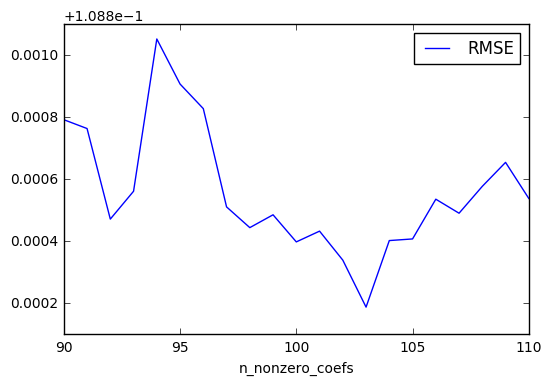

In [50]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=55)
omp_params = {'n_nonzero_coefs': np.arange(90, 111, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [53]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=103)

In [54]:
validate(omp_regr)

0.12368609556938975

## XGBoost

In [45]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 5021.72 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.003)
Parameters: {'reg_alpha': 0.93437948135833582, 'colsample_bytree': 0.91600274153535732, 'learning_rate': 0.10658997895523015, 'min_child_weight': 0.48062647193618369, 'n_estimators': 299, 'subsample': 0.69132483911540499, 'reg_lambda': 0.24253401997381116, 'max_depth': 6, 'gamma': 0.041041090589041998}

Model with rank: 2
Mean validation score: -0.014 (std: 0.003)
Parameters: {'reg_alpha': 1.0044327713225565, 'colsample_bytree': 0.67181981052187989, 'learning_rate': 0.43762731690551115, 'min_child_weight': 0.18571227811455351, 'n_estimators': 398, 'subsample': 0.92138542155004866, 'reg_lambda': 0.22932298516296787, 'max_depth': 2, 'gamma': 0.0034341580129753483}

Model with rank: 3
Mean validation score: -0.014 (std: 0.003)
Parameters: {'reg_alpha': 0.44193498461644987, 'colsample_bytree': 0.93185176462135622, 'learning_rate': 0.57595598771850653, 

n_estimators                    RMSE                 std dev
0          100.0  0.11462330377929823289  0.04915070756958286879
1          200.0  0.10972012468792714801  0.05031727018880762653
2          300.0  0.10890189878445676042  0.04989894036478966649
7          800.0  0.10867870664544546089  0.05044131732027800491
9         1000.0  0.10861796484488082937  0.05064486657449034090
10        1100.0  0.10861596831673517305  0.05048399176798183674
6          700.0  0.10859456870497045944  0.05040856488916398148
8          900.0  0.10858824460526167455  0.05059852244431121970
13        1400.0  0.10857894737193234114  0.05055201116924955274
14        1500.0  0.10857641824334934855  0.05063370438373894500
5          600.0  0.10856786324852349401  0.05054144417087785834
12        1300.0  0.10856608477582732619  0.05053511250582295999
4          500.0  0.10854235535015788194  0.05029544440243036152
3          400.0  0.10854131497124744343  0.05032980950027234751
11        1200.0  0.10851271282168106769  0.05042072400034777052

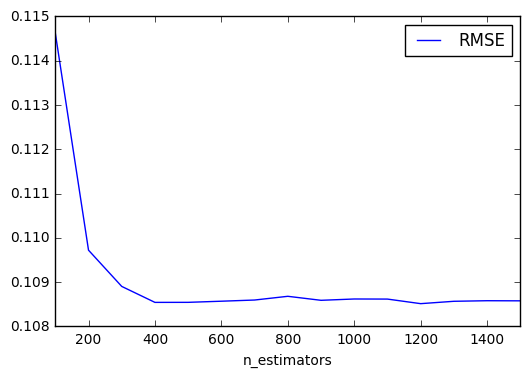

In [83]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 3, 
    min_child_weight = 4.1,
    gamma = 0.01,
    subsample = 0.8,
    colsample_bytree = 0.4,
    reg_alpha = 0.9,
    reg_lambda = 0.2, 
    learning_rate = 0.09,
    n_estimators = 299,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(100, 1600, 100).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [84]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 3, 
    min_child_weight = 4.1,
    gamma = 0.01,
    subsample = 0.8,
    colsample_bytree = 0.4,
    reg_alpha = 0.9,
    reg_lambda = 0.2, 
    learning_rate = 0.09,
    n_estimators = 1200,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [85]:
validate(xgb_regr)

0.12525802497078753

## MLP Regressor

In [46]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [47]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 997.54 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.018 (std: 0.003)
Parameters: {'alpha': 4.5692733753639631e-05, 'max_iter': 324.11804582367563, 'tol': 0.00011508295819844777, 'hidden_layer_sizes': 488}

Model with rank: 2
Mean validation score: -0.018 (std: 0.004)
Parameters: {'alpha': 2.6813332939469843e-05, 'max_iter': 225.71295440865825, 'tol': 9.6945198060351351e-05, 'hidden_layer_sizes': 357}

Model with rank: 3
Mean validation score: -0.018 (std: 0.004)
Parameters: {'alpha': 0.0003232343237252024, 'max_iter': 381.27327444085256, 'tol': 0.00010351945698829497, 'hidden_layer_sizes': 139}



max_iter                    RMSE                 std dev
0       25.0  0.19809633302661502907  0.08127726686779657150
1       50.0  0.13806192677344544806  0.06553850481000694783
2       75.0  0.12444580232730502456  0.05900707538283974513
3      100.0  0.11871848015191668879  0.05592552794591888060
4      125.0  0.11534332125764790167  0.05214983818875869315
5      150.0  0.11363232870693999732  0.05173978300922766477
6      175.0  0.11318626550212178283  0.05384312614712433859
8      225.0  0.11291487224314963878  0.05449100634572365265
10     275.0  0.11284717195754484509  0.05233017556124983094
9      250.0  0.11283757709938492531  0.05390712319539366082
7      200.0  0.11275876314390666233  0.05394475305502679369
11     300.0  0.11243258764820775186  0.05231844909113436692
12     325.0  0.11177680078479251824  0.05099678564422051308
13     350.0  0.11167559002382243527  0.05243561059181379991
14     375.0  0.11159050016264239480  0.05238008016701469621
15     400.0  0.11158699865739470092  0.05242924885072676455

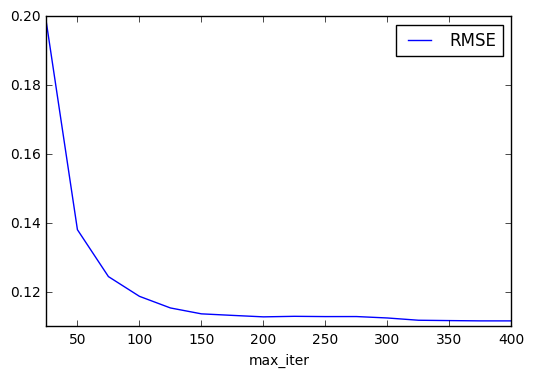

In [78]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(2, ),
                        alpha=0.00005, 
                        tol=0.00012, 
                        max_iter=324)
mlp_params = {'max_iter': np.arange(25, 425, 25).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['max_iter'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [80]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(2, ),
                        alpha=0.00005, 
                        tol=0.00012, 
                        max_iter=400)

In [81]:
validate(mlp_regr)

0.12692074514128873